# 4. model creation, evaluation, and output

Create model based on prior feature engineering (see appendix 1 workbook), cross-validate, and generate final output

1. Preliminary OLS modeling
2. Model investigation w/ GridSearchCV
3. Validation w/ K-fold
4. Modeling on final test set
5. Generate final output for presentation

### Set up

In [343]:
from __future__ import print_function, division
#Import BeautifulSoup
from bs4 import BeautifulSoup
#Regular expressions compiler
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import pickle

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline
# %pylab inline

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [344]:
#Functions:

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [345]:
with open('pickles/hosp2.pickle','rb') as read_file:
    hosp = pickle.load(read_file)
    
hosp_full = hosp.copy()
# hosp.info()

In [346]:
# Create relevant variables from prior investigations

#interaction term
hosp['MHIxSCH'] = hosp['median_household_income']*hosp['some_college_or_higher']
#box-cox transformed bed count
lamb=stats.boxcox_normmax(hosp['bed_count'], brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
hosp['bed_count_bc']=(np.power(hosp['bed_count'],-lamb)-1)/-lamb

#remove non-relevant variables
drop_cols = ['avg_PRR','avg_ERR','avg_EXCESS',
                  'number_of_readmissions','measure_name',
                  'provider_id','start_date','end_date','hospital_name','state',
                  'zip_code','county_name','hospital_type','county_st','3_Year_Avg_Hourly_Wage',
                  'PRR_imputed','nod_imputed','hospital_overall_rating_2','hospital_overall_rating_3','hospital_overall_rating_4','hospital_overall_rating_5',
                  'hospital_ownership_Nonprofit_Other',
                  'hospital_ownership_Other',
                  'hospital_ownership_Private_Nonprofit',
                  'hospital_ownership_Proprietary',
                  'medical_imaging_better_than_national_average',
                  'medical_imaging_same_as_national_average',
                  'effectiveness_of_care_better_than_national_average',
                  'effectiveness_of_care_same_as_national_average',
                  'timeliness_of_care_same_as_national_average', 
                  'safety_of_care_same_as_national_average',
                  'some_college_or_higher','emergency_services_True',
                  'median_household_income','FY_Wage_Index','Case_Mix_Indexes','bed_count','med_school_affiliation'
            ]

# 'Case_Mix_Indexes','FY_Wage_Index',

X, y = hosp.drop(drop_cols, axis = 1), hosp['avg_PRR']
col_names = X.columns

Lambda: 0.022029489310371186


In [347]:
#Create train+val and test sets (80/20)
X_tr, X_te, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 51)

#scale on train+val and fit on train+val and test
std = StandardScaler()
std.fit(X_tr.values)
X_train = std.transform(X_tr.values)
X_test = std.transform(X_te.values)

In [348]:
#keep standard deviations of non-standardized data for later reference
hosp_stats = X_tr.describe()
stdevs = hosp_stats.iloc[2,:]

## 1. Preliminary OLS modeling

In [349]:
list(zip([i for i in range(len(col_names))], col_names))

[(0, 'number_of_discharges'),
 (1, 'mortality_better_than_national_average'),
 (2, 'mortality_same_as_national_average'),
 (3, 'safety_of_care_better_than_national_average'),
 (4, 'patient_experience_better_than_national_average'),
 (5, 'patient_experience_same_as_national_average'),
 (6, 'timeliness_of_care_better_than_national_average'),
 (7, 'rural'),
 (8, 'MHIxSCH'),
 (9, 'bed_count_bc')]

In [350]:
lr = sm.OLS(y_train, sm.add_constant(X_train))
# Fit the model
fit = lr.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     72.66
Date:                Thu, 10 Oct 2019   Prob (F-statistic):          6.15e-126
Time:                        18:44:08   Log-Likelihood:                -3782.3
No. Observations:                1902   AIC:                             7587.
Df Residuals:                    1891   BIC:                             7648.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4747      0.041    405.295      0.000      16.395      16.554
x1            -0.1629      0.050     -3.255      0.001      -0.261      -0.065
x2            -0.6725      0.053    -12.629      0.000      -0.777      -0.568
x3            -0.6229      0.056    -11.056      0.000      -0.733      -0.512
x4             0.1436      0.042      3.395      0.001       0.061       0.227
x5            -0.4137      0.048     -8.550      0.000      -0.509      -0.319
x6            -0.3220      0.047     -6.844      0.000      -0.414      -0.230
x7             0.2919      0.045      6.416      0.000       0.203       0.381
x8             0.2112      0.048      4.362      0.000       0.116       0.306
x9            -0.5174      0.046    -11.292      0.000      -0.607      -0.428
x10            0.3923      0.053      7.364      0.000       0.288       0.497
==============================================================================
Omnibus:                       69.187   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.956
Skew:                           0.449   Prob(JB):                     1.18e-17
Kurtosis:                       3.423   Cond. No.                         2.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [351]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif["features"] = col_names
vif

,VIF Factor,features
0,1.517087,number_of_discharges
1,1.716277,mortality_better_than_national_average
2,1.920937,mortality_same_as_national_average
3,1.082382,safety_of_care_better_than_national_average
4,1.417200,patient_experience_better_than_national_average
5,1.339540,patient_experience_same_as_national_average
6,1.252472,timeliness_of_care_better_than_national_average
7,1.417985,rural
8,1.270395,MHIxSCH
9,1.717451,bed_count_bc


## 2. Model investigation w/ GridSearchCV

### Ridge

In [352]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
from sklearn.model_selection import GridSearchCV
alphavec = 10**np.linspace(-2,2,200)

a = {'alpha':alphavec}
ridge_model2 = GridSearchCV(Ridge(), param_grid=a, cv=5)
ridge_model2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [353]:
# ridge_model2.alpha_
alpha_rm2 = ridge_model2.best_estimator_.alpha
alpha_rm2

28.660676169482503

In [354]:
list(zip(col_names,ridge_model2.best_estimator_.coef_))

[('number_of_discharges', -0.1524440802784816),
 ('mortality_better_than_national_average', -0.6435552063901913),
 ('mortality_same_as_national_average', -0.5938484246215957),
 ('safety_of_care_better_than_national_average', 0.14344414385560883),
 ('patient_experience_better_than_national_average', -0.405516791682712),
 ('patient_experience_same_as_national_average', -0.3139429671165766),
 ('timeliness_of_care_better_than_national_average', 0.29144519178579115),
 ('rural', 0.207376636274638),
 ('MHIxSCH', -0.5046693232513451),
 ('bed_count_bc', 0.38768767104366064)]

In [355]:
# Make predictions on the test set using the new model
test_set_pred_r2 = ridge_model2.predict(X_test)

In [356]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_r2)

1.3647240243340455

In [357]:
r2_score(y_test, test_set_pred_r2)

0.27831537843571164

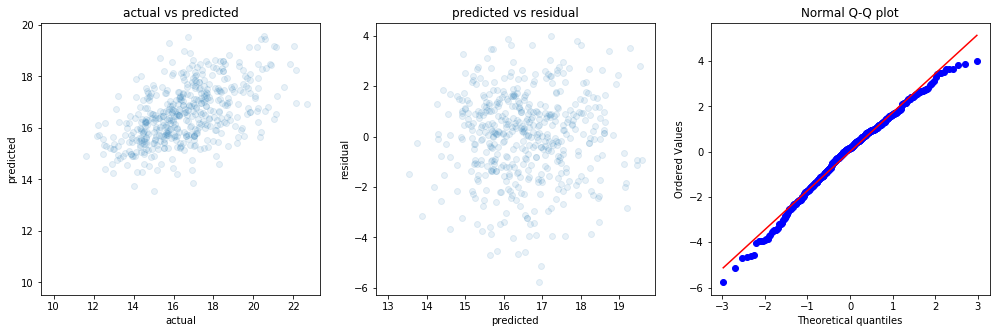

In [358]:
test_set_resid_r2 = test_set_pred_r2-y_test

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5))
ax1.scatter(y_test,test_set_pred_r2, alpha=.1);
ax1.plot(np.linspace(10,24,1), np.linspace(10,24,1))
ax1.set_title('actual vs predicted')
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.scatter(test_set_pred_r2, test_set_resid_r2, alpha=.1);
ax2.plot(np.linspace(13,18,1), np.linspace(-4,4,1))
ax2.set_title('predicted vs residual')
ax2.set_xlabel('predicted')
ax2.set_ylabel('residual');
stats.probplot(test_set_resid_r2, dist="norm", plot=plt)
ax3.set_title("Normal Q-Q plot");

### LASSO

In [359]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

# lasso_model2 = LassoCV(alphas = alphavec, cv=5)
# lasso_model2.fit(X_tr, y_train)

a = {'alpha':alphavec}
lasso_model2 = GridSearchCV(Lasso(), param_grid=a, cv=5)
lasso_model2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.203...
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [360]:
alpha_lm2 = lasso_model2.best_estimator_.alpha
alpha_lm2

0.01

In [361]:
list(zip(col_names, lasso_model2.best_estimator_.coef_))

[('number_of_discharges', -0.13890735132820572),
 ('mortality_better_than_national_average', -0.640008153051457),
 ('mortality_same_as_national_average', -0.5892294383110765),
 ('safety_of_care_better_than_national_average', 0.13743450232902957),
 ('patient_experience_better_than_national_average', -0.4016971326715601),
 ('patient_experience_same_as_national_average', -0.30865656377624423),
 ('timeliness_of_care_better_than_national_average', 0.28837396929595405),
 ('rural', 0.20009270639228183),
 ('MHIxSCH', -0.4991535524862314),
 ('bed_count_bc', 0.38290039674863485)]

In [362]:
# Make predictions on the test set using the new model
test_set_pred_l2 = lasso_model2.predict(X_test)

In [363]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_l2)

1.3637170145442634

In [364]:
r2_score(y_test, test_set_pred_l2)

0.27925546726110606

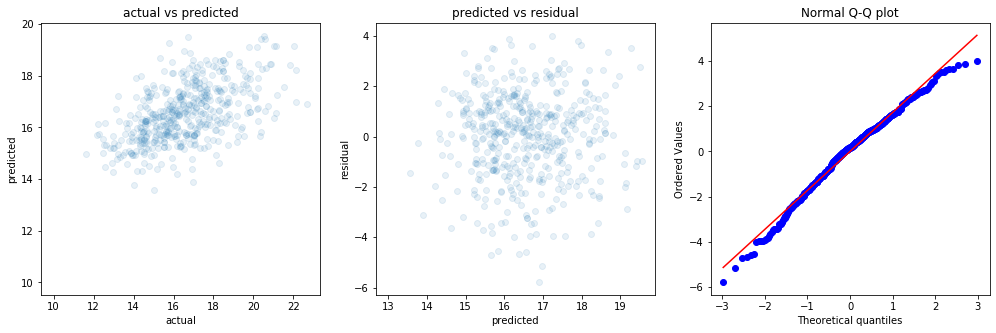

In [365]:
test_set_resid_l2 = test_set_pred_l2-y_test

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5))
ax1.scatter(y_test,test_set_pred_l2, alpha=.1);
ax1.plot(np.linspace(10,24,1), np.linspace(10,24,1))
ax1.set_title('actual vs predicted')
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.scatter(test_set_pred_l2, test_set_resid_l2, alpha=.1);
ax2.plot(np.linspace(13,18,1), np.linspace(-4,4,1))
ax2.set_title('predicted vs residual')
ax2.set_xlabel('predicted')
ax2.set_ylabel('residual');
stats.probplot(test_set_resid_l2, dist="norm", plot=plt)
ax3.set_title("Normal Q-Q plot");

In [366]:
# Lars path visualization
# std = StandardScaler()
# std.fit(X_train.values)
# X_tr = std.transform(X_train.values)

## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_train, y_train.values, method='lasso')


Computing regularization path using the LARS ...


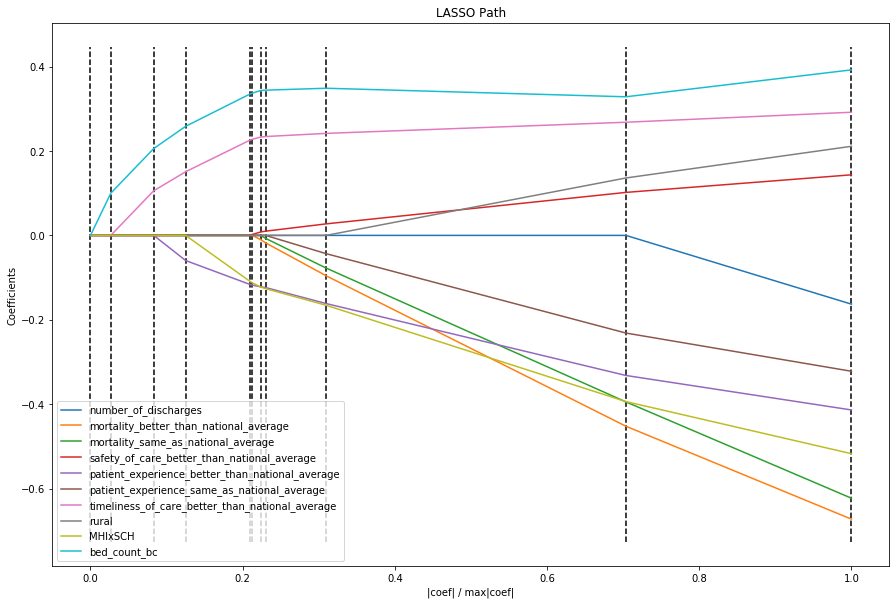

In [367]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(15,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(col_names, loc = 'lower left')
plt.show()

### Elastic Net

In [368]:
elnet_model2 = GridSearchCV(ElasticNet(), param_grid=a, cv=5)
elnet_model2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1....
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scor

In [369]:
alpha_en2 = elnet_model2.best_estimator_.alpha
alpha_en2

0.01

In [370]:
# Make predictions on the test set using the new model
test_set_pred_e2 = elnet_model2.predict(X_test)

In [371]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred_e2)

1.3643286967777775

In [372]:
r2_score(y_test, test_set_pred_e2)

0.2785907155888454

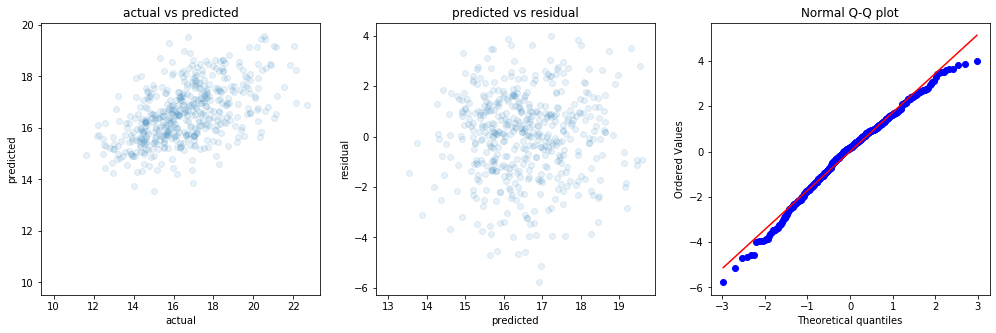

In [373]:
test_set_resid_e2 = test_set_pred_e2-y_test

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5))
ax1.scatter(y_test,test_set_pred_e2, alpha=.1);
ax1.plot(np.linspace(10,24,1), np.linspace(10,24,1))
ax1.set_title('actual vs predicted')
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.scatter(test_set_pred_e2, test_set_resid_e2, alpha=.1);
ax2.plot(np.linspace(13,18,1), np.linspace(-4,4,1))
ax2.set_title('predicted vs residual')
ax2.set_xlabel('predicted')
ax2.set_ylabel('residual');
stats.probplot(test_set_resid_e2, dist="norm", plot=plt)
ax3.set_title("Normal Q-Q plot");

NOTES: validation set indicates similar performance regardless ridge/lasso/elnet

## 3. Validation w/ K-fold

Vaidate models on full data set

In [374]:
lm = LinearRegression()
lm_ridge = Ridge(alpha=alpha_rm2)
lm_lasso = Lasso(alpha=alpha_lm2)
lm_elnet = ElasticNet(alpha=alpha_en2)

In [375]:
kf = KFold(n_splits=3, shuffle=True, random_state = 66)

print(f"Linear Regression mean val R^2: {np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')):.4f}")
print(f"Ridge Regression mean val R^2: {np.mean(cross_val_score(lm_ridge, X_train, y_train, cv=kf, scoring='r2')):.4f}")
print(f"Lasso Regression mean val R^2: {np.mean(cross_val_score(lm_lasso, X_train, y_train, cv=kf, scoring='r2')):.4f}")
print(f"Elastic Net Regression mean val R^2: {np.mean(cross_val_score(lm_elnet, X_train, y_train, cv=kf, scoring='r2')):.4f}")

Linear Regression mean val R^2: 0.2678
Ridge Regression mean val R^2: 0.2674
Lasso Regression mean val R^2: 0.2672
Elastic Net Regression mean val R^2: 0.2675


In [376]:
print(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2'))
print(cross_val_score(lm_ridge, X_train, y_train, cv=kf, scoring='r2'))
print(cross_val_score(lm_lasso, X_train, y_train, cv=kf, scoring='r2'))
print(cross_val_score(lm_elnet, X_train, y_train, cv=kf, scoring='r2'))

[0.27275356 0.23981735 0.29085195]
[0.273693   0.23828549 0.29032708]
[0.27337191 0.238091   0.29011731]
[0.27336652 0.23868377 0.29045026]


NOTES: scores are not significantly improved w/ = stick with Linear

## 4. Final model performance

X and y are standardized combined train and validation sets

In [377]:
#Linear Regression
lm.fit(X_train,y_train)
print(f'Linear Regression v1 val R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression v1 val R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression v1 val R^2: 0.278
Linear Regression v1 val R^2: 0.277


In [378]:
#GridSearchCV Ridge model
lm_ridge.fit(X_train,y_train)
print(f'Ridge Regression v2 val R^2: {lm_ridge.score(X_train, y_train):.3f}')
print(f'Ridge Regression v2 val R^2: {lm_ridge.score(X_test, y_test):.3f}')

Ridge Regression v2 val R^2: 0.277
Ridge Regression v2 val R^2: 0.278


In [379]:
#GridSearchCV Lasso model
lm_lasso.fit(X_train,y_train)
print(f'Lasso Regression v2 val R^2: {lm_lasso.score(X_train, y_train):.3f}')
print(f'Lasso Regression v2 val R^2: {lm_lasso.score(X_test, y_test):.3f}')

Lasso Regression v2 val R^2: 0.277
Lasso Regression v2 val R^2: 0.279


In [380]:
#GridSearchCV Elastic Net model
lm_elnet.fit(X_train,y_train)
print(f'Elastic Net Regression v2 val R^2: {lm_lasso.score(X_train, y_train):.3f}')
print(f'Elastic Net Regression v2 val R^2: {lm_lasso.score(X_test, y_test):.3f}')

Elastic Net Regression v2 val R^2: 0.277
Elastic Net Regression v2 val R^2: 0.279


In [381]:
# list(zip(col_names, lm_ridge.best_estimator_.coef_))

## 5. Generate results

#### Test performance

In [382]:
lm_pred_y_test = lm.predict(X_test)
lm_resid_test = lm_pred_y_test-y_test

In [383]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, lm_pred_y_test)

1.3655298618782572

In [384]:
r2_score(y_test, lm_pred_y_test)

0.27681932517958896

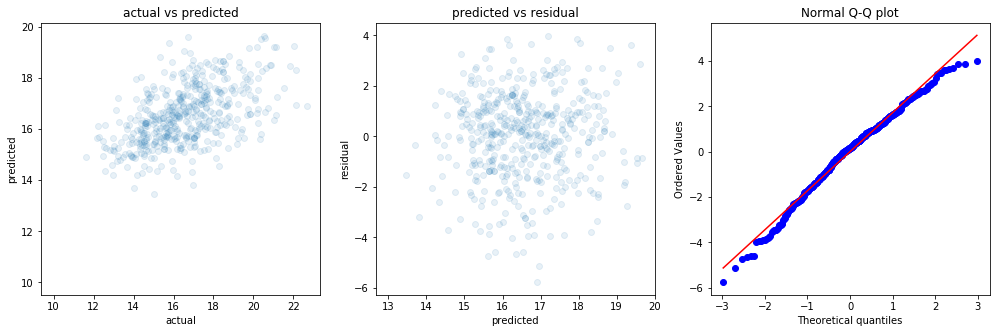

In [385]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5))
ax1.scatter(y_test,lm_pred_y_test, alpha=.1);
ax1.plot(np.linspace(10,24,1), np.linspace(10,24,1))
ax1.set_title('actual vs predicted')
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.scatter(lm_pred_y_test, lm_resid_test, alpha=.1);
ax2.plot(np.linspace(13,18,1), np.linspace(-4,4,1))
ax2.set_title('predicted vs residual')
ax2.set_xlabel('predicted')
ax2.set_ylabel('residual');
stats.probplot(lm_resid_test, dist="norm", plot=plt)
ax3.set_title("Normal Q-Q plot");

### Train performance

In [386]:
lm_pred_y_train = lm.predict(X_train)
lm_resid_train = lm_pred_y_train-y_train

In [387]:
# Find the MAE and R^2 on the test set using this model
mae(y_train, lm_pred_y_train)

1.4029874615965945

In [388]:
r2_score(y_train, lm_pred_y_train)

0.2775845464793265

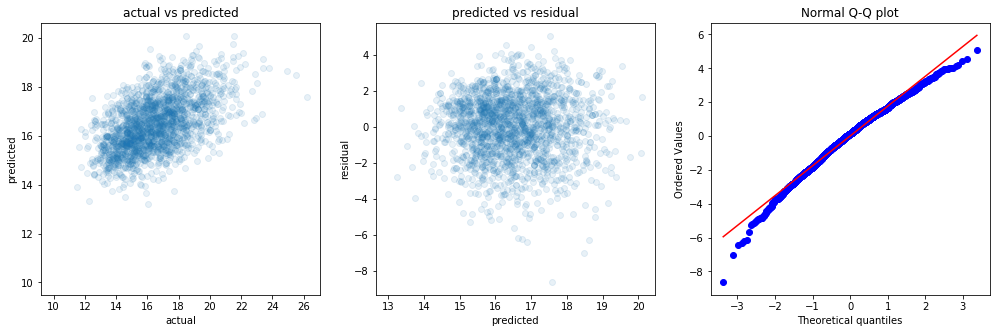

In [389]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(17,5))
ax1.scatter(y_train,lm_pred_y_train, alpha=.1);
ax1.plot(np.linspace(10,24,1), np.linspace(10,24,1))
ax1.set_title('actual vs predicted')
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.scatter(lm_pred_y_train, lm_resid_train, alpha=.1);
ax2.plot(np.linspace(13,18,1), np.linspace(-4,4,1))
ax2.set_title('predicted vs residual')
ax2.set_xlabel('predicted')
ax2.set_ylabel('residual');
stats.probplot(lm_resid_train, dist="norm", plot=plt)
ax3.set_title("Normal Q-Q plot");

### Output results and remove standardization of beta coefficients

In [390]:
lr = sm.OLS(y_train, sm.add_constant(X_train))
# Fit the model
fit = lr.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avg_PRR   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     72.66
Date:                Thu, 10 Oct 2019   Prob (F-statistic):          6.15e-126
Time:                        18:44:20   Log-Likelihood:                -3782.3
No. Observations:                1902   AIC:                             7587.
Df Residuals:                    1891   BIC:                             7648.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4747      0.041    405.295      0.000      16.395      16.554
x1            -0.1629      0.050     -3.255      0.001      -0.261      -0.065
x2            -0.6725      0.053    -12.629      0.000      -0.777      -0.568
x3            -0.6229      0.056    -11.056      0.000      -0.733      -0.512
x4             0.1436      0.042      3.395      0.001       0.061       0.227
x5            -0.4137      0.048     -8.550      0.000      -0.509      -0.319
x6            -0.3220      0.047     -6.844      0.000      -0.414      -0.230
x7             0.2919      0.045      6.416      0.000       0.203       0.381
x8             0.2112      0.048      4.362      0.000       0.116       0.306
x9            -0.5174      0.046    -11.292      0.000      -0.607      -0.428
x10            0.3923      0.053      7.364      0.000       0.288       0.497
==============================================================================
Omnibus:                       69.187   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.956
Skew:                           0.449   Prob(JB):                     1.18e-17
Kurtosis:                       3.423   Cond. No.                         2.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [446]:
from scipy.special import inv_boxcox

inv_boxcox(std.scale_[-1], lamb)

1.9889766719447683

In [466]:
fit.params[1:]/np.insert(std.scale_[:-1], len(std.scale_)-1, inv_boxcox(std.scale_[-1], lamb))

x1    -4.465853e-04
x2    -1.895216e+00
x3    -1.348494e+00
x4     2.976275e-01
x5    -9.299851e-01
x6    -6.791696e-01
x7     5.948402e-01
x8     5.318147e-01
x9    -3.738038e-07
x10    1.972434e-01
dtype: float64

In [437]:
std.scale_

array([3.64865686e+02, 3.54841294e-01, 4.61924944e-01, 4.82414108e-01,
       4.44897173e-01, 4.74119013e-01, 4.90655447e-01, 3.97052236e-01,
       1.38403011e+06, 6.92854678e-01])

In [445]:
np.insert(std.scale_[:-1], len(std.scale_)-1, inv_boxcox(std.scale_[-1], lamb))

array([3.64865686e+02, 3.54841294e-01, 4.61924944e-01, 4.82414108e-01,
       4.44897173e-01, 4.74119013e-01, 4.90655447e-01, 3.97052236e-01,
       1.38403011e+06, 1.98897667e+00])

### Save data

In [391]:
# Pickle fit2 to a file 
fit.save('results/lm_model_sm.pickle')

In [392]:
from sklearn.externals import joblib
joblib.dump(lm, 'results/lm_model_sklearn.pickle')

['results/lm_model_sklearn.pickle']

## Format visuals

### predicted vs actual for test data

In [450]:
color1 = '#f5734f'
color2 = '#feae55'
colorbg = "#eeeeee"
colorslide = '#00517c'
colortext = '#374957'

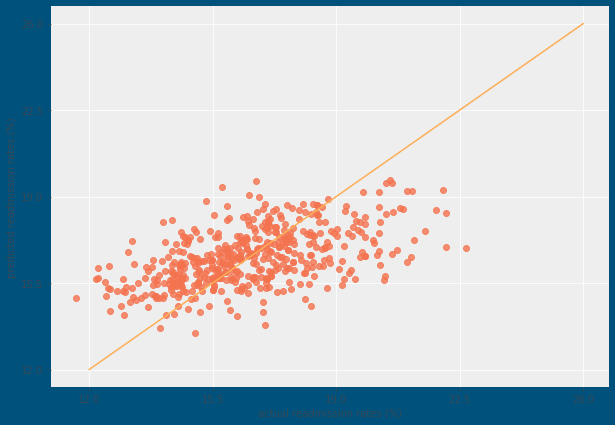

In [462]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,7))

fig.patch.set_facecolor(colorslide)
ax.scatter(y_test,lm_pred_y_test, alpha=.8, color = color1)
ax.plot([12,26],[12,26],color = color2)
ax.grid(color='white')
ax.set_axisbelow(True) #grid behind data
ax.set_xlabel('actual readmission rates (%)',color=colortext)
ax.set_ylabel('predicted readmission rates (%)',color= colortext)
ax.set_xticks(np.linspace(12, 26, 5))
ax.set_yticks(np.linspace(12, 26, 5))
ax.set_facecolor(colorbg)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', colors= colortext)
ax.tick_params(axis='y', colors= colortext)

fig.savefig("figures/actual_predicted.png", bbox_inches = 'tight', transparent=True);

In [395]:
r2_score(y_test,lm_pred_y_test)

0.27681932517958896

### predicted vs residuals

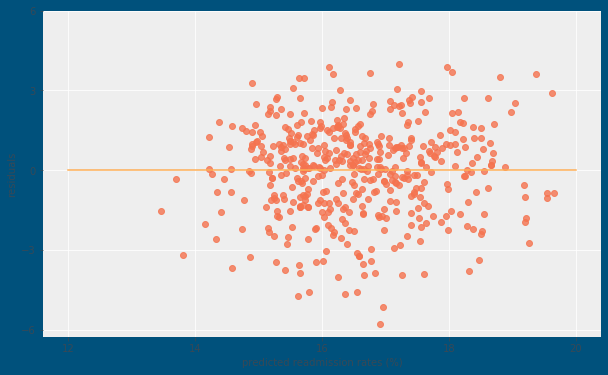

In [464]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,6))

fig.patch.set_facecolor(colorslide)
ax.scatter(lm_pred_y_test,lm_resid_test, alpha=0.8, color = color1)
ax.plot([12,20],[0,0],color = color2)
ax.grid(color='white')
ax.set_axisbelow(True) #grid behind data
ax.set_xlabel('predicted readmission rates (%)',color=colortext)
ax.set_ylabel('residuals',color=colortext)
ax.set_xticks(np.linspace(12, 20, 5))
ax.set_yticks(np.linspace(-6, 6, 5))
ax.set_facecolor(colorbg)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', colors=colortext)
ax.tick_params(axis='y', colors=colortext)

fig.savefig("figures/predicted_residuals.png", bbox_inches = 'tight',transparent=True);

In [397]:
# QQ plot


# ax.get_lines()[0].set_marker('p')
# ax.get_lines()[0].set_markerfacecolor('r')
# ax.get_lines()[0].set_markersize(12.0)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# stats.probplot(lm_resid_test, dist="norm", plot=plt)
# ax.set_title("Normal Q-Q plot")
# ax.get_lines()[0].set_marker(color1)
# ax.get_lines()[0].set_markerfacecolor(color2)
# plt.show();

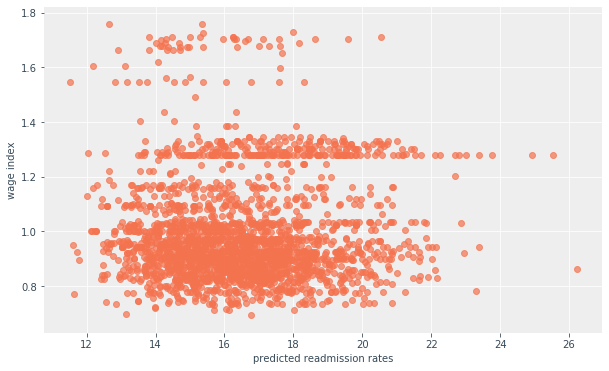

In [458]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,6))

ax.scatter(hosp_full['avg_PRR'],hosp_full['FY_Wage_Index'],color=color1,alpha=0.7)
ax.set_facecolor(colorbg)
ax.grid(color='white')
ax.set_xlabel('predicted readmission rates',color=colortext)
ax.set_ylabel('wage index',color=colortext)
ax.set_axisbelow(True) #grid behind data
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', colors=colortext)
ax.tick_params(axis='y', colors=colortext)
fig.savefig("figures/wageindex_RR.png", bbox_inches = 'tight',transparent=True);

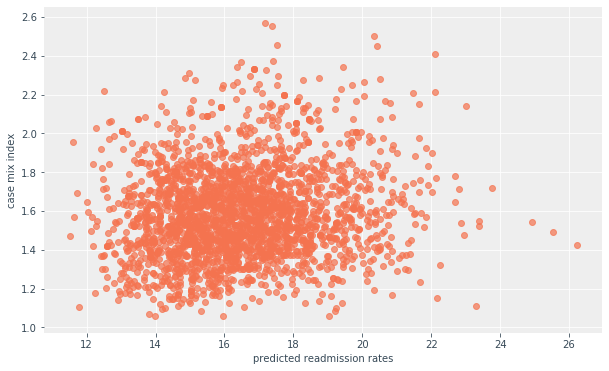

In [459]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,6))

ax.scatter(hosp_full['avg_PRR'],hosp_full['Case_Mix_Indexes'],color=color1,alpha=0.7)
ax.set_facecolor(colorbg)
ax.grid(color='white')
ax.set_xlabel('predicted readmission rates', color=colortext)
ax.set_ylabel('case mix index',color=colortext)
ax.set_axisbelow(True) #grid behind data
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='x', colors=colortext)
ax.tick_params(axis='y', colors=colortext)
fig.savefig("figures/casemixindex_RR.png", bbox_inches = 'tight',transparent=True);

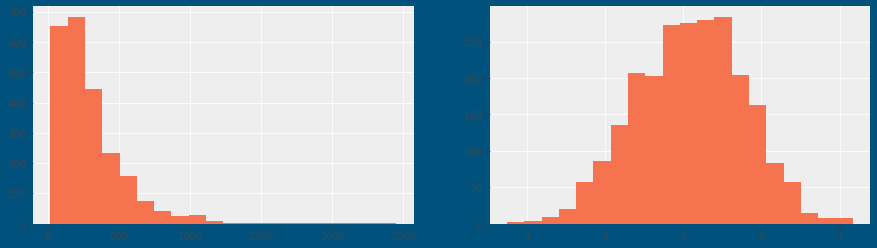

In [453]:
#bed count transformation

hosp_full['bed_count_bc']=(np.power(hosp_full['bed_count'],-lamb)-1)/-lamb


fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,4))
fig.patch.set_facecolor(colorslide)
ax1.hist(hosp_full['bed_count'],bins=20,color=color1);
# ax1.set_title('bed count')
ax1.grid(color='white')
ax1.set_axisbelow(True) #grid behind data
ax1.set_facecolor(colorbg)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='x', colors=colortext)
ax1.tick_params(axis='y', colors=colortext)

ax2.hist(hosp_full['bed_count_bc'],bins=20,color=color1)
# ax2.set_title('bed count log')
ax2.grid(color='white')
ax2.set_axisbelow(True) #grid behind data
ax2.set_facecolor(colorbg)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='x', colors=colortext)
ax2.tick_params(axis='y', colors=colortext)
fig.savefig("figures/bedcount.png", bbox_inches = 'tight',transparent=True);